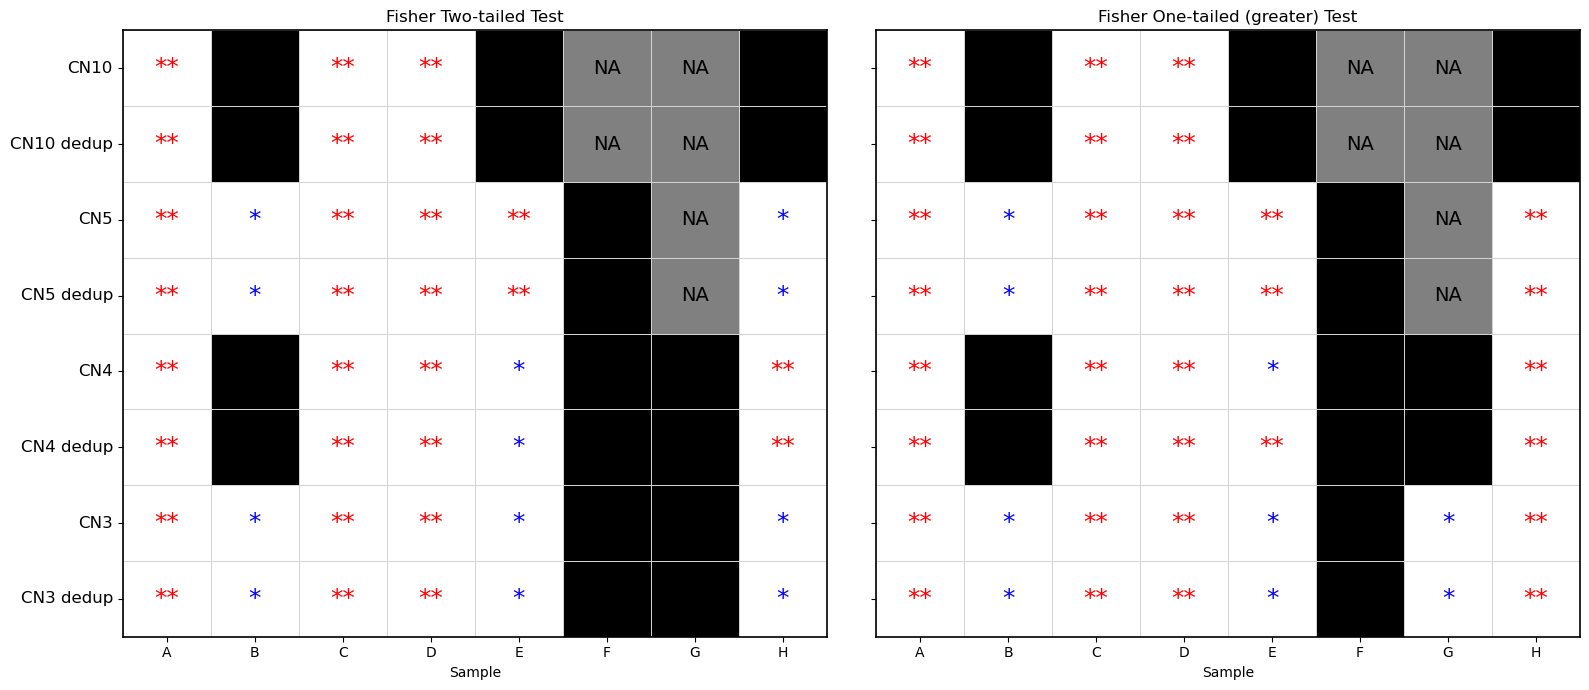

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
from matplotlib.colors import ListedColormap

# Load and combine your CSVs
file_paths = glob.glob("*_fisher_test_results.csv")

data_list = []

for file in file_paths:
    df = pd.read_csv(file, skiprows=1)
    df.columns = ["Sample", "Odds Ratio", "Fisher Two-tailed p-value", "Fisher One-tailed (greater) p-value"]
    
    setting_raw = file.split("/")[-1].split("_fisher_test_results.csv")[0]
    df["Setting"] = setting_raw
    
    data_list.append(df)

# Combine data
if not data_list:
    raise ValueError("No _fisher_test_results.csv files found in the directory.")

df_combined = pd.concat(data_list)

# Extract sample letter (A-H)
df_combined["Sample"] = df_combined["Sample"].str.extract(r'-DNA_([A-H])')[0]

# Function to preprocess for each p-value type
def preprocess(df, value_col):
    pivot = df.pivot(index="Setting", columns="Sample", values=value_col)
    annot = pivot.copy().astype(str)

    for row in annot.index:
        for col in annot.columns:
            val = pivot.loc[row, col]
            if pd.isna(val) or val == 1:
                annot.loc[row, col] = "NA"
            elif val < 0.01:
                annot.loc[row, col] = "**"
            elif val < 0.05:
                annot.loc[row, col] = "*"
            else:
                annot.loc[row, col] = ""

    color_map = pivot.copy()
    color_map[:] = 0  # default black
    color_map[pivot < 0.05] = 1  # white for significant
    color_map[pivot.isna() | (pivot == 1)] = 0.5  # gray for NA or p=1

    return color_map, annot

# Process both p-value types
fisher_colors, fisher_annot = preprocess(df_combined, "Fisher Two-tailed p-value")
chi2_colors, chi2_annot = preprocess(df_combined, "Fisher One-tailed (greater) p-value")

# Custom order
custom_order = ["CN10", "CN10 dedup", "CN5", "CN5 dedup", "CN4", "CN4 dedup", "CN3", "CN3 dedup"]

# Reorder both color and annotation DataFrames
fisher_colors = fisher_colors.reindex(custom_order)
fisher_annot = fisher_annot.reindex(custom_order)

chi2_colors = chi2_colors.reindex(custom_order)
chi2_annot = chi2_annot.reindex(custom_order)

# Custom black-gray-white colormap
bw_colormap = ListedColormap(["black", "gray", "white"])

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Fisher Two-tailed Test
sns.heatmap(fisher_colors, cmap=bw_colormap, cbar=False,
            linewidths=0.5, linecolor='lightgrey', ax=axes[0],
            yticklabels=fisher_colors.index)

# Annotations
for i in range(fisher_annot.shape[0]):
    for j in range(fisher_annot.shape[1]):
        text = fisher_annot.iloc[i, j]
        if text != '':
            if text == '**':
                color = 'red'
                size = 18
            elif text == '*':
                color = 'blue'
                size = 18
            elif text == 'NA':
                color = 'black'
                size = 14
            else:
                color = 'black'
                size = 10

            axes[0].text(j + 0.5, i + 0.5, text, ha='center', va='center', color=color, fontsize=size)

axes[0].set_title("Fisher Two-tailed Test")
axes[0].set_yticklabels(fisher_colors.index, rotation=0, fontsize=12)
axes[0].set_ylabel("")

# Fisher One-tailed (greater) Test
sns.heatmap(chi2_colors, cmap=bw_colormap, cbar=False,
            linewidths=0.5, linecolor='lightgrey',ax=axes[1],
            yticklabels = False)  # no labels here

for i in range(chi2_annot.shape[0]):
    for j in range(chi2_annot.shape[1]):
        text = chi2_annot.iloc[i, j]
        if text != '':
            if text == '**':
                color = 'red'
                size = 18
            elif text == '*':
                color = 'blue'
                size = 18
            elif text == 'NA':
                color = 'black'
                size = 14
            else:
                color = 'black'
                size = 10

            axes[1].text(j + 0.5, i + 0.5, text, ha='center', va='center', color=color, fontsize=size)
        
axes[1].set_yticks(axes[0].get_yticks())
axes[1].set_yticklabels([])
axes[1].set_title("Fisher One-tailed (greater) Test")
axes[1].set_ylabel("")

plt.subplots_adjust(wspace=2)
# Tidy layout
plt.tight_layout()
for ax in axes:
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.2)
        spine.set_edgecolor("black")
# Apply custom-colored y-axis labels manually
plt.subplots_adjust(wspace=0.07)

plt.show()
